In [1]:
# when want to test on test data you have to write
# test_set.dataset.__test__() 
# which now means that all images loaded in (even ones from train & val would have no data augmentation)

In [2]:
# import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import cv2
from PIL import Image, ImageOps
from sklearn.metrics import f1_score
from scipy import stats
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import AlexNet
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from skimage import io, transform
import os
from torch.autograd import Variable

In [3]:
# import for visualisation of network
!pip install graphviz
!pip install torchviz
import graphviz
import torchviz


In [4]:
# use GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # if on CUDA machine -> should print a CUDA device:
!nvidia-smi  # tells you what GPU you're on

cuda:0
Invalid combination of input arguments. Please run 'nvidia-smi -h' for help.



In [5]:
# change path to correct folder 


#from google.colab import drive
#drive.mount('/content/gdrive')
#PATH_OF_DATA= '/content/gdrive/"My Drive"/data/"HNSCC_slices"' # see content of dataset
#!ls {PATH_OF_DATA} # datasets.ImageFolder() expects data as root/label/picture.png
#root = '/content/gdrive/My Drive/data/HNSCC_slices' # note lack of " "


# if doing locally 


# computer

#from google.colab import drive
#drive.mount('/content/gdrive')
#PATH_OF_DATA = r'C:\Users\olive\OneDrive\Documents\HNSCC_slices-20201116T001636Z-001.zip\HNSCC_slices' # see content of dataset
#!ls {PATH_OF_DATA} # datasets.ImageFolder() expects data as root/label/picture.png
root = r'C:\Users\olive\OneDrive\Documents\HNSCC_slices' # note lack of " "
import os
print(os.getcwd())
os.chdir(root)
print(os.getcwd())




C:\Users\olive\OneDrive\Documents\CNN\Report
C:\Users\olive\OneDrive\Documents\HNSCC_slices


In [6]:
# define normalisation 
norm_mean = 1024+100
norm_std = 1000
mask_mean = 0.9346
mask_centre_mean = 0.1538

In [7]:
# custom dataset class for the images and masks

import cv2
import random
import sklearn
import skimage.transform as tr
import skimage

def mask_to_point(mask):
  x_coord = 0
  y_coord = 0
  counter = 0
  for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      if (mask[i][j] == 1):
        x_coord += i
        y_coord += j
        counter += 1

  x_one = int(x_coord/counter)
  y_one = int(y_coord/counter)
  mask = np.zeros(shape = mask.shape)
  mask[x_one][y_one] = 1
  return mask

class SliceDataset(Dataset):
    """2D CT Scan dataset."""

    def __init__(self, root, transform_train =None, transform_test = None, test = False):
        """
        Args:
            root (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = root
        self.imgs = list(sorted(os.listdir(os.path.join(root, "CTs")))) # ensure they're aligned & index them
        self.masks = list(sorted(os.listdir(os.path.join(root, "Masks"))))
        self.masks_centres = list(sorted(os.listdir(os.path.join(root, "Mask Centres"))))
        self.transform_train = transform_train
        self.transform_test = transform_test
        self.test = False
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx): # convert tensor to list to index items
            idx = idx.tolist() 
        img_path = os.path.join(self.root, "CTs", self.imgs[idx]) # image path is combination of root and index 
        mask_path = os.path.join(self.root, "Masks", self.masks[idx])
        mask_centre_path = os.path.join(self.root, "Mask Centres", self.masks_centres[idx])

        img = np.load(img_path) # image read in as numpy array
        mask = np.load(mask_path) # mask - think 0 = background
        mask_centre = np.load(mask_centre_path)

        sample = {'image': img, 'mask': mask, 'mask_centre': mask_centre} # both are nd.arrays, stored in sample dataset

        if (self.transform_train) and (self.test == False):
            sample = self.transform_train(sample) # if transforms present, act on sample
        if (self.transform_test) and (self.test == True):
            sample = self.transform_test(sample) # if transforms present, act on sample
        if (mask.max() != mask.min()): # exclude images where no mask
          #print('mask_max:%5.2f, mask_min:%5.2f' % (mask.max(),mask.min()))
          #print('x where its equal to 1')
          #print((np.where(mask == mask.max())[0]))
          return sample 
    
    def __len__(self):
        return len(self.imgs) # get size of dataset

    def __test__(self):
      self.test = True
    
    def __train__(self):
      self.train = False


class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        sample = self.subset[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.subset)


class Rescale(object): # need to change rescale so longer side is matched to int and then pad
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # int keeps aspect ratio the same
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, mask_centre = sample['image'], sample['mask'], sample['mask_centre'] # getting mask and image from sample so can operate on them
        #print('before resize')
        #print(mask.max())
        #print(mask.min())
        h, w = image.shape[:2] # define image height and width as first two values in shape
        if isinstance(self.output_size, int): # maintain aspect ratio so no loss of info
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w),preserve_range = True, anti_aliasing = True) # anti-aliasing was false
        # h and w are swapped for mask because for images,
        # x and y axes are axis 1 and 0 respectively
        mask = transform.resize(mask, (new_h,new_w), preserve_range = True,  anti_aliasing = True) # anti-aliasing was false
        mask_centre =  transform.resize(mask_centre, (new_h,new_w), preserve_range = True, anti_aliasing = True)
        #print('after resize')
        #print(mask.max())
        #print(mask.min())
        return {'image': img, 'mask': mask, 'mask_centre': mask_centre}

class Normalise(object):  
  """ Normalise CT scan in the desired examination window
      takes in image as numpy """
  
  def __init__(self, level, window):
      self.level = level
      self.window = window
      self.level_mask_centre = level * (mask_centre_mean/norm_mean) # note cause mask/mask_centre/img have different values
      self.window_mask_centre =  window * (mask_centre_mean/norm_mean)
      self.level_mask = level * (mask_mean/norm_mean)
      self.window_mask = window * (mask_mean/norm_mean)
                          
  def __call__(self, sample):
      image, mask, mask_centre = sample['image'], sample['mask'], sample['mask_centre']
      # image
      minval = self.level - self.window/2
      maxval = self.level + self.window/2
      img_norm = np.clip(image, minval, maxval)
      img_norm -= minval
      img_norm /= self.window
      # mask
      minval_mask = self.level_mask - self.window_mask/2
      maxval_mask = self.level_mask + self.window_mask/2
      mask_norm = np.clip(mask, minval_mask, maxval_mask)
      mask_norm -= minval_mask
      mask_norm /= self.window_mask
      # mask centre
      minval_mask_centre = self.level_mask_centre - self.window_mask_centre/2
      maxval_mask_centre = self.level_mask_centre + self.window_mask_centre/2
      mask_centre_norm = np.clip(mask_centre, minval_mask_centre, maxval_mask_centre)
      mask_centre_norm -= minval_mask_centre
      mask_centre_norm /= self.window_mask_centre
      return {'image':img_norm, 'mask': mask, 'mask_centre': mask_centre} # note note !

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask, mask_centre = sample['image'], sample['mask'], sample['mask_centre']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = torch.from_numpy(image).float() # dont know why images/mask casted to float here but need to do it again later
        mask = torch.from_numpy(mask).float()
        mask = mask.unsqueeze(0) # force mask to have extra dimension i.e. (1xHxW)
        image = image.unsqueeze(0)
        mask_centre = torch.from_numpy(mask_centre).float()
        mask_centre = mask_centre.unsqueeze(0)
        return {'image': image,'mask': mask, 'mask_centre': mask_centre}

class HorizontalFlip(object):
  """ Flip images """
  def __call__(self,sample):
    image, mask,mask_centre = sample['image'], sample['mask'], sample['mask_centre']
    if random.random() <= 0.5:
      transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1)])
      image = transform(image)
      mask = transform(mask)
      mask_centre = transform(mask_centre)
    return {'image': image, 'mask': mask, 'mask_centre': mask_centre}

class Rotation(object):  
  """ Random rotate images """
  def __call__(self,sample):
    image, mask, mask_centre = sample['image'], sample['mask'], sample['mask_centre']
    if random.random() <= 0.5:
        angle = random.randint(-10, 10)
        image = tr.rotate(image, angle)
        mask = tr.rotate(mask, angle)
        mask_centre = tr.rotate(mask_centre, angle)
    return {'image': image, 'mask': mask, 'mask_centre': mask_centre}


class Shifting(object): 
  """ Random shift images """
  def __call__(self,sample):
    image, mask,mask_centre = sample['image'], sample['mask'], sample['mask_centre']
    if random.random() <= 0.5:
        translation_x = random.randint(-30, 30)
        translation_y = random.randint(-30,30)
        transform = tr.AffineTransform(translation = (translation_x,translation_y))
        image = tr.warp(image,transform) # default is padding with zeros
        mask = tr.warp(mask,transform)
        mask_centre = tr.warp(mask_centre,transform)
    return {'image': image, 'mask': mask, 'mask_centre': mask_centre}

class Noise(object):  # helps prevent overfitting
  """ Random noise images """
  def __call__(self,sample):
    image, mask,mask_centre = sample['image'], sample['mask'], sample['mask_centre']
    if random.random() <= 0.5:
      image = skimage.util.random_noise(image, mean = 0, var = 0.0000000001, clip = False)
      # would this work given that mask is unchanged??
    return {'image': image, 'mask': mask, 'mask_centre': mask_centre}

class GaussBlur(object):  # helps prevent overfitting
  """ Gaussian blur images """
  def __call__(self,sample):
    image, mask, mask_centre = sample['image'], sample['mask'],sample['mask_centre']
    if random.random() <= 0.5:
      image = cv2.GaussianBlur(image,(3,3),0)
      # do i want to blur the mask??
    return {'image': image, 'mask': mask, 'mask_centre':mask_centre}


def coords_max(heatmap): # assumes 1 channel
  # heatmap is batch of either masks or image of 
  # heatmap dim is (B x C x H x W)
  # output is (B x coord)
  # i.e. x,y of 3rd image = coords[3][0],coords[3][1] only 1 channel
  b = torch.max(heatmap,dim =3,keepdim = True)
  c = torch.max(b[0],dim = 2,keepdim = True)
  batch_size = (heatmap.size()[0])
  for i in range(batch_size):
    y = c[1][i][0][0][0]
    x = b[1][i][0][y][0]
    if i == 0:
      coords = torch.tensor([[x,y]])
    else: 
      coords_temp = torch.tensor([[x,y]])
      coords = torch.cat((coords,coords_temp),dim = 0)

  return coords      

from scipy import optimize

def gaussian_new(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian_new(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

# fit 2D gauss and find maximum of it - just use for performance metrics as for other will be slow
def gauss_max(heatmap): # assumes 1 channel
    # heatmap is batch of masks or images of dim (B x C x H x W)
    # output is (B x coord)
    # i.e. x,y of 3rd image = coords[3][0], coords[3][1] only 1 channel
    batch_size = (heatmap.size()[0])
    heatmap = heatmap.detach().cpu().numpy()
    for i in range(batch_size):
        params = fitgaussian(heatmap[i][0])
        x = params[2]
        y =  params[1]  
        x_max = heatmap.shape[3]
        y_max = heatmap.shape[2]
        x = max(0,min(x,x_max)) # keep x & y in [0,224]
        y = max(0,min(y,y_max))
        if i == 0:
            coords = torch.tensor([[x,y]])
        else: 
            coords_temp = torch.tensor([[x,y]])
            coords = torch.cat((coords,coords_temp),dim = 0)
    return coords    
        


In [8]:
"""
mask_list = list(sorted(os.listdir(os.path.join(root, "Masks"))))
  
for idx in range(1778):  
  mask_path = os.path.join(root, "Masks", mask_list[idx])
  mask = np.load(mask_path) # mask - think 0 = background
  mask_centre = mask_to_point(mask)
  model_save_name = (mask_list[idx])
  path = F"/content/gdrive/My Drive/data/HNSCC_slices/Mask Centres/{model_save_name}" 
  np.save(path, mask_centre) 

"""

'\nmask_list = list(sorted(os.listdir(os.path.join(root, "Masks"))))\n  \nfor idx in range(1778):  \n  mask_path = os.path.join(root, "Masks", mask_list[idx])\n  mask = np.load(mask_path) # mask - think 0 = background\n  mask_centre = mask_to_point(mask)\n  model_save_name = (mask_list[idx])\n  path = F"/content/gdrive/My Drive/data/HNSCC_slices/Mask Centres/{model_save_name}" \n  np.save(path, mask_centre) \n\n'

In [9]:
# transformations and normalization

#tensor(1067.6926)
#tensor(0.9346)
#tensor(0.1538)"


# rotation gaussblu noise
# same transformations for train/val/test
trans_plain = transforms.Compose([Rescale(224),Normalise(norm_mean,norm_std),ToTensor()]) # trans 1 # was 0.0326, 1
#trans = transforms.Compose([Rescale(224),Normalise(0.0326,1),ToTensor(), HorizontalFlip()]) # trans 2
trans_augment = transforms.Compose([Rescale(224),Rotation(),  GaussBlur(),Noise(), Shifting(), Normalise(norm_mean,norm_std),ToTensor(), HorizontalFlip()])# trans 3
# note how unsure about noise & gaussian blur -> how to implement
# how to implement erasing etc?
# note warning here for perspective distortion

dataset = SliceDataset(root, transform_train = trans_augment, transform_test = trans_plain, test = False )

# split data in train/val/test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


image_datasets = {
    'train': train_set, 'val': val_set, 'test':test_set
}
batch_size = 1

# Load data in
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_set,batch_size = batch_size, shuffle = False, num_workers=0)
}


print(train_set.__getitem__(0)['image'].size()) # i.e. 1 x 224 x 224 as torch tensor (C x H x W)
print(train_set.__getitem__(0)['mask'].size()) 
print(train_set.__getitem__(0)['mask_centre'].size()) 

h,w 500 500
new h, new w 224 224
torch.Size([1, 224, 224])
h,w 500 500
new h, new w 224 224
torch.Size([1, 224, 224])
h,w 500 500
new h, new w 224 224
torch.Size([1, 224, 224])


In [10]:
# check data loaded in correctly

import torchvision.utils

def reverse_transform(img): # to plot original image loaded in 
    # could do reverse of normalisation here
    img = img.numpy().transpose((1,2,0))
    img_numpy = np.squeeze(img) # gets rid of dead channel axis (H x W x 1)
    return img_numpy


# calculate mean of spine
"""
test_set.dataset.__test__() # sets whole dataset to test mode means it doesn't augment images


# calculate mean of spine


batch_total = 0 # total spine value
number_batches = 0 
mask_total = 0
mask_centre_total = 0

for batch in dataloaders['train']:
    image = batch['image']
    mask_centre = batch['mask_centre']
    mask = batch['mask']
    
    spine_value = 0
    mask_centre_value = 0
    mask_value = 0
    for k in range(image.size(0)): # goes through every image in batch
        mask_coords_max = coords_max(mask_centre)
        x, y = mask_coords_max[k][0], mask_coords_max[k][1]
        spine_value += image[k][0][y][x]
        mask_value += mask[k][0][y][x]
        mask_centre_value += mask_centre[k][0][y][x]
    batch_total +=  spine_value/image.size(0)
    mask_total += mask_value/image.size(0)
    mask_centre_total += mask_centre_value/image.size(0)
    
    number_batches += 1 
    print('batches complete:')
    print(number_batches)



batch_mean = batch_total/number_batches
mask_mean = mask_total/number_batches
mask_centre_mean = mask_centre_total/number_batches
print(batch_mean)
print(mask_mean)
print(mask_centre_mean)




for batch in dataloaders['train']:
  
  print('new_image')
  for k in range(image.size(0)):
      fig = plt.figure()
      ax = fig.add_subplot(111)
      x, y = coords_max(mask_centre)[k][0],coords_max(mask_centre)[k][1]
      plot_image = reverse_transform(image[k])
      plot_mask = reverse_transform(mask[k])
      plot_mask_centre = reverse_transform(mask_centre[k])
      print('x')
      print('y')
      print(x)
      print(y)
      print(plot_image[x][y])
      print(plot_image[112,112])
      plt.imshow(plot_image, cmap='Greys_r',vmin=plot_image.min(), vmax=plot_image.max(),alpha = 1.0)
      plt.imshow(plot_mask,cmap='Reds', alpha = 0.2)
      plt.imshow(plot_mask_centre, cmap = 'Blues', alpha = 0.2)
      plt.show()

"""


"\ntest_set.dataset.__test__() # sets whole dataset to test mode means it doesn't augment images\n\n\n# calculate mean of spine\n\n\nbatch_total = 0 # total spine value\nnumber_batches = 0 \nmask_total = 0\nmask_centre_total = 0\n\nfor batch in dataloaders['train']:\n    image = batch['image']\n    mask_centre = batch['mask_centre']\n    mask = batch['mask']\n    \n    spine_value = 0\n    mask_centre_value = 0\n    mask_value = 0\n    for k in range(image.size(0)): # goes through every image in batch\n        mask_coords_max = coords_max(mask_centre)\n        x, y = mask_coords_max[k][0], mask_coords_max[k][1]\n        spine_value += image[k][0][y][x]\n        mask_value += mask[k][0][y][x]\n        mask_centre_value += mask_centre[k][0][y][x]\n    batch_total +=  spine_value/image.size(0)\n    mask_total += mask_value/image.size(0)\n    mask_centre_total += mask_centre_value/image.size(0)\n    \n    number_batches += 1 \n    print('batches complete:')\n    print(number_batches)\n\n\n

In [11]:

from torch import nn


class UNET(nn.Module): # need to add bottleneck
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 64, 3, 1)
        self.conv2 = self.contract_block(64, 128, 3, 1)
        self.conv3 = self.contract_block(128, 128, 3, 1)
        self.conv4 = self.contract_block(128, 128, 3, 1)
        self.dropout = nn.Dropout2d(p=0.5)
        self.pool = self.pooling_layer()

        self.bottleneck = self.bottleneck_block(128, 256, 128, 3, 1)

        self.upconv4 = self.expand_block(128*2, 128, 3, 1)
        self.upscale_4 = self.upscale_layer(128)
        self.upconv3 = self.expand_block(128*2, 128, 3, 1)
        self.upscale_3 = self.upscale_layer(128)
        self.upconv2 = self.expand_block(128*2, 64, 3, 1)
        self.upscale_2 = self.upscale_layer(64)
        self.final_conv = self.final_block(64*2, out_channels, 3, 1)



    def __call__(self, x):

        # downsampling part
        # encode the input image into feature representations at multiple different levels.
        conv1 = self.conv1(x)
        pool1 = self.pool(conv1)
        conv2 = self.conv2(pool1)
        #drop1 = self.dropout(conv2)
        pool2 = self.pool(conv2)
        conv3 = self.conv3(pool2)
        #drop2 = self.dropout(conv3)
        pool3 = self.pool(conv3)
        conv4 = self.conv4(pool3)
        #drop2 = self.dropout(conv3)
        

        # bottleneck
        # force the model to learn a compression of the input data.
        # compressed view should only contain the “useful” information to
        # reconstruct the input (or segmentation map).
        pool4 = self.pool(conv4)
        bottleneck1 = self.bottleneck(pool4)
        #bottleneck2 = self.bottleneck(bottleneck1

        # expand block concatenate conv4 and bottleneck output

        upconv4 = self.upconv4(torch.cat([bottleneck1, conv4], 1))
        upscale_conv_4 = self.upscale_4(upconv4)
        upconv3 = self.upconv3(torch.cat([upscale_conv_4, conv3], 1))
        upscale_conv_3 = self.upscale_3(upconv3)
        upconv2 = self.upconv2(torch.cat([upscale_conv_3, conv2], 1))
        upscale_conv_2 = self.upscale_2(upconv2)
        final_layer = self.final_conv(torch.cat([upscale_conv_2, conv1], 1))

        return final_layer


    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
                            )
        return expand

    def bottleneck_block(self, in_channels, mid_channels, out_channels, kernel_size, padding):

      bottleneck = nn.Sequential(
          nn.Conv2d(in_channels, mid_channels, kernel_size = kernel_size, stride = 1, padding = padding),#, stride = 1, padding =1),
          nn.ReLU(),
          nn.BatchNorm2d(mid_channels),
          nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=1, padding=padding),
          nn.ReLU(),
          nn.BatchNorm2d(mid_channels),
          nn.ConvTranspose2d(mid_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, output_padding=1) #??
          )
      return bottleneck
    
    def pooling_layer(self):

      pool = nn.Sequential (
          nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      return pool

    def upscale_layer(self, channels):

      upscale = nn.Sequential(
          nn.ConvTranspose2d(channels, channels, kernel_size = 3, stride = 2, padding = 1, output_padding=1) #??
      )
      return upscale


    def final_block(self, in_channels, out_channels, kernel_size, padding):

        final_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return final_block



In [12]:
#@title Ed Network
  
# from Ed try this out
class Enc_Dec_2D(nn.Module):
    def __init__(self, filter_factor=1, targets=1, in_channels=1):
        super(Enc_Dec_2D, self).__init__()
        ff = filter_factor # filter factor (easy net scaling)
        # Input --> (in_channels, x, x) --> x needs to be a factor of 4 (downsampled by x0.5 twice)
        # conv layers set 1 - down 1
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=int(16*ff), kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(int(16*ff))
        self.drop1 = nn.Dropout2d(p=0.5)
        self.c2 = nn.Conv2d(in_channels=int(16*ff), out_channels=int(32*ff), kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(int(32*ff))
        self.drop2 = nn.Dropout2d(p=0.5)
        # conv layers set 2 - down 2
        self.c3 = nn.Conv2d(in_channels=int(32*ff), out_channels=int(32*ff), kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(int(32*ff))
        self.drop3 = nn.Dropout2d(p=0.5)
        self.c4 = nn.Conv2d(in_channels=int(32*ff), out_channels=int(64*ff), kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(int(64*ff))
        self.drop4 = nn.Dropout2d(p=0.5)
        # conv layers set 3 - base
        self.c5 = nn.Conv2d(in_channels=int(64*ff), out_channels=int(64*ff), kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(int(64*ff))
        self.drop5 = nn.Dropout2d(p=0.5)
        self.c6 = nn.Conv2d(in_channels=int(64*ff), out_channels=int(64*ff), kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(int(64*ff))
        self.drop6 = nn.Dropout2d(p=0.5)
        # upsample 1
        self.rc_1 = nn.Conv2d(in_channels=int(64*ff), out_channels=int(64*ff), kernel_size=3, padding=1)
        self.bn_r1 = nn.BatchNorm2d(int(64*ff))
        self.drop_r1 = nn.Dropout2d(p=0.5)
        # conv layer set 4 - up 1
        self.c7 = nn.Conv2d(in_channels=int(64*ff), out_channels=int(32*ff), kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(int(32*ff))
        self.drop7 = nn.Dropout2d(p=0.5)
        self.c8 = nn.Conv2d(in_channels=int(32*ff), out_channels=int(32*ff), kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(int(32*ff))
        self.drop8 = nn.Dropout2d(p=0.5)
        # upsample 2
        self.rc_2 = nn.Conv2d(in_channels=int(32*ff), out_channels=int(32*ff), kernel_size=3, padding=1)
        self.bn_r2 = nn.BatchNorm2d(int(32*ff))
        self.drop_r2 = nn.Dropout2d(p=0.5)
        # conv layer set 5 - up 2
        self.c9 = nn.Conv2d(in_channels=int(32*ff), out_channels=int(16*ff), kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(int(16*ff))
        self.drop9 = nn.Dropout2d(p=0.5)
        self.c10 = nn.Conv2d(in_channels=int(16*ff), out_channels=int(16*ff), kernel_size=3, padding=1)
        self.bn10 = nn.BatchNorm2d(int(16*ff))
        self.drop10 = nn.Dropout2d(p=0.5)
        # prediction convolution
        self.pred = nn.Conv2d(in_channels=int(16*ff), out_channels=int(targets), kernel_size=1)
    
    def forward(self, im):
        # Down block 1
        x = F.relu(self.bn1(self.c1(im)))
        x = self.drop1(x)
        x = F.relu(self.bn2(self.c2(x)))
        skip1 = self.drop2(x)
        x = F.max_pool2d(skip1, (2,2))
        # Down block 2
        x = F.relu(self.bn3(self.c3(x)))
        x = self.drop3(x)
        x = F.relu(self.bn4(self.c4(x)))
        skip2 = self.drop4(x)
        x = F.max_pool2d(skip2, (2,2))
        # Base block 
        x = F.relu(self.bn5(self.c5(x)))
        x = self.drop5(x)
        x = F.relu(self.bn6(self.c6(x)))
        x = self.drop6(x)
        # Upsample 1
        x = F.relu(self.bn_r1(self.rc_1(F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False))))
        x = self.drop_r1(x)
        # Up block 1
        x = F.relu(self.bn7(self.c7(x+skip2)))
        x = self.drop7(x)
        x = F.relu(self.bn8(self.c8(x)))
        x = self.drop8(x)
        # Upsample 2
        x = F.relu(self.bn_r2(self.rc_2(F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False))))
        x = self.drop_r2(x)
        # Up block 2
        x = F.relu(self.bn9(self.c9(x+skip1)))
        x = self.drop9(x)
        x = F.relu(self.bn10(self.c10(x)))
        x = self.drop10(x)
        # Predict
        return self.pred(x)

In [13]:
class SCNET(nn.Module): # need to add bottleneck
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Local appearance

        # block 1
        self.conv1 = self.conv_block1(in_channels, 64, 3, 1)
        self.conv2 = self.conv_block1(64, 128, 3, 1)
        self.conv3 = self.conv_block1(128,128,3, 1)

        # block 2
        self.pool_block_2 = self.pool_layer_block_2()

        # block 3
        self.conv4 = self.conv_block3(128, 128, 3, 1) # note conv4 acts on pool, which acts on conv2
        self.conv5 = self.conv_block3(128, 128, 3, 1)
        self.conv6 = self.conv_block3(128,128,3, 1)

        # block 4
        self.pool_block_4 = self.pool_layer_block_4()

        # block 5
        self.conv7 = self.conv_block5(128, 128, 3, 1) # note conv7 acts on pool, which acts on conv5
        self.conv8 = self.conv_block5(128, 128, 3, 1)
        self.conv9 = self.conv_block5(128,128,3, 1)

        # block 6
        self.upsample_block_6 = self.upsample_layer_block_6(128)

        # block 7
        # addition
        self.upsample_block_7 = self.upsample_layer_block_7(128)


        # block 8
        # addition
        self.conv10 = self.conv_block8(128, 1, 3, 1)

        # Spatial configuration

        # block 9
        self.pool_block_9 = self.pool_layer_block_9()

        # block 10
        self.conv11 = self.conv_block10(1, 64, 3, 1) 
        self.conv12 = self.conv_block10(64, 128, 3, 1)
        self.conv13 = self.conv_block10(128,128,3, 1)

        # block 11
        self.upsample_block_11 = self.upsample_layer_block_11(128, 1)

        # block 12
        # multiplication


    def __call__(self, x):

        # block 1
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        # block 2
        pool_block_2 = self.pool_block_2(conv2) # note middle one

        # block 3
        conv4 = self.conv4(pool_block_2)
        conv5 = self.conv5(conv4)
        conv6 = self.conv6(conv5)

        # block 4
        pool_block_4 = self.pool_block_4(conv5)

        # block 5
        conv7 = self.conv7(pool_block_4)
        conv8 = self.conv8(conv7)
        conv9 = self.conv9(conv8)

        # block 6
        upsample_block_6 = self.upsample_block_6(conv9)

        # block 7
        add_block_7 = conv6 + upsample_block_6
        upsample_block_7 = self.upsample_block_7(add_block_7)

        # block 8
        add_block_8 = upsample_block_7 + conv3
        conv10 = self.conv10(add_block_8)

        # block 9
        pool_block_9 = self.pool_block_9(conv10)

        # block 10
        conv11 = self.conv11(pool_block_9)
        conv12 = self.conv12(conv11)
        conv13 = self.conv13(conv12)

        # block 11
        upsample_block_11 = self.upsample_block_11(conv13)

        # block 12
        output = upsample_block_11 * conv10

        return output

    def conv_block1(self, in_channels, out_channels, kernel_size, padding):

        conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, padding = padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return conv_block1

    def pool_layer_block_2(self):

        pool_layer_block_2 = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )

        return pool_layer_block_2
    
    def conv_block3(self, in_channels, out_channels, kernel_size, padding):

        conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, padding = padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return conv_block2

    def pool_layer_block_4(self):

        pool_layer_block_4 = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )

        return pool_layer_block_4
    
    def conv_block5(self, in_channels, out_channels, kernel_size, padding):

        conv_block5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, padding = padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return conv_block5
    
    def upsample_layer_block_6(self, channels):

        upsample_block_6 = nn.Sequential(
          nn.ConvTranspose2d(channels, channels, kernel_size = 3, stride = 2, padding = 1, output_padding=1) #??
        )
        return upsample_block_6
    
    def upsample_layer_block_7(self, channels):

        upsample_block_7 = nn.Sequential(
          nn.ConvTranspose2d(channels, channels, kernel_size = 3, stride = 2, padding = 1, output_padding=1) #??
        )
        return upsample_block_7

    def conv_block8(self, in_channels, out_channels, kernel_size, padding):

        conv_block8 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, padding = padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return conv_block8

    def pool_layer_block_9(self):

        pool_layer_block_9 = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )

        return pool_layer_block_9

    def conv_block10(self, in_channels, out_channels, kernel_size, padding):

        conv_block10 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, padding = padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return conv_block10

    def upsample_layer_block_11(self, in_channels, out_channels):

        upsample_block_11 = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, output_padding=1) #??
        )
        return upsample_block_11


# Model summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNET(1,1)
model = model.to(device)

from torchsummary import summary
summary(model, input_size=(1, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       640
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-13                      147,584
|    └─BatchNorm2d: 2-14                 256
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      147,584
|    └─BatchNorm2d: 2-17                 256
|    └─ReLU: 2-18                        

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       640
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-13                      147,584
|    └─BatchNorm2d: 2-14                 256
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      147,584
|    └─BatchNorm2d: 2-17                 256
|    └─ReLU: 2-18                        

In [14]:
# loss and train functions

from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.nn as nn
from __future__ import print_function




def point_to_point(mask_x, mask_y, pred_x, pred_y):
  # calculates point to point error for image
  point_to_point = ((pred_x - mask_x)**2 + (pred_y - mask_y)**2)**0.5
  return point_to_point

# returns gaussian function 
def gaussian(x,y, targ_coords, sigma, gamma, dimension = 2): # assumes in 2d space
  # x, y are general coords and targ_coords define mean of gaussian
  x_targ, y_targ = targ_coords[0], targ_coords[1]
  l2_dif = torch.tensor(-((x-x_targ)**2 + (y- y_targ)**2)/(2*sigma**2))
  gauss = torch.tensor((gamma) * (2*np.pi)**(-dimension/2) * sigma ** (-dimension) ** torch.exp(l2_dif))
  return gauss

def gaussian_map(peak_x,peak_y,sigma,gamma,x_size,y_size,output,dimension = 2): # 2D gaussian 5x5 image
  if output == False: # expands gaussian map to 448x448 to ensure proper normalisation ? not working
    y,x = np.ogrid[0:2*y_size,0:2*x_size]
    peak_x = peak_x + x_size/2
    peak_y = peak_y + y_size/2
    pre_factor = ((gamma) * (2*np.pi)**(-dimension/2) * sigma ** (-dimension)) 
    h = pre_factor * torch.exp( -((torch.tensor(x).to(device)-peak_x)**2 + (torch.tensor(y).to(device)-peak_y)**2) / (2.*sigma*sigma) )
  if output == True:
    y,x = np.ogrid[0:y_size,0:x_size]
    pre_factor = ((gamma) * (2*np.pi)**(-dimension/2) * sigma ** (-dimension)) 
    h = pre_factor * torch.exp( -((torch.tensor(x).to(device)-peak_x)**2 + (torch.tensor(y).to(device)-peak_y)**2) / (2.*sigma*sigma) )
  return h

# L2 loss for gaussian heat maps
def calc_loss_gauss(pred, target, target_centre, metrics, alpha, reg, gamma, epoch_samples, sigma): 
    # loss function for difference between gaussian heat maps
    # pred is gaussian heatmap & need to convert target to gaussian heatmap
    target_batch_coords = coords_max(target_centre)


   

    batch_size = target_batch_coords.size()[0]
    total_batch_loss = 0
    total_sum_loss = 0
    total_reg_loss = 0
    total_alpha_loss = 0
    total_x_posn = 0
    total_y_posn = 0
    total_x_targ_posn = 0
    total_y_targ_posn = 0
    total_point_to_point = 0
    
    
    for i in range(batch_size): # i.e. for each image/mask in batch
      targ_coords = target_batch_coords[i]
      img_number = epoch_samples + i # epoch_samples is 0, 32, 64 e.g. if batch is size 32

      # because of normalisation need to make sure not putting mask at 0,0
      if (targ_coords[0] == 0) or (targ_coords[1] == 0) or (targ_coords[0] == 223) or (targ_coords[1] == 223):
        print('----------------------ERROR-----------------------')
      
      x_size = target.size()[3]
      y_size = target.size()[2] 

      # average x/y posn
      total_x_posn += coords_max(pred)[i][0] # change
      total_y_posn += coords_max(pred)[i][1] # change
      total_x_targ_posn += targ_coords[0]
      total_y_targ_posn += targ_coords[1]

      # average point to point
      total_point_to_point += point_to_point(targ_coords[0],targ_coords[1],coords_max(pred)[i][0],coords_max(pred)[i][1]) # change
     
      # note how this is True because need targ_gaus to be 224x224 -> need to convert to potentially making a 448x448 image from output
      targ_gaus = gaussian_map(targ_coords[0],targ_coords[1],sigma,gamma,x_size,y_size,output = True) 

      # try normalising mean and targ gaus see if helps
      pred_heatmap = pred[i].squeeze()
      #pred_heatmap_norm = (pred_heatmap - torch.mean(pred_heatmap))/torch.std(pred_heatmap)
      #targ_gaus = (targ_gaus - torch.mean(targ_gaus))/torch.std(targ_gaus)

      img_loss = ((((pred_heatmap - targ_gaus)**2)).sum()) # multiply by targ gaus for box normalisation
      sum_loss = ((((pred_heatmap - targ_gaus)**2)).sum())
      
      # regularization term
      squ_weights = torch.tensor(0,dtype=torch.float64).to(device)
      for model_param_name, model_param_value in model.named_parameters():
        if model_param_name.endswith('weight'):
          squ_weights += (model_param_value.norm())**2
      
      regularization = (reg * squ_weights)
      reg_loss = regularization
      
      img_loss += alpha * (sigma.norm())**2 + regularization
      alpha_loss = alpha * (sigma.norm())**2

      # add to loss
      total_batch_loss += img_loss
      total_sum_loss += sum_loss
      total_reg_loss += reg_loss
      total_alpha_loss += alpha_loss

      # print for every epoch_samples = 0 -> i.e first image in epoch
      if epoch_samples == 0:
        print(' ---- first image of set ---- (start)')
        print('targ: (%5.2f,%5.2f)' % (targ_coords[0],targ_coords[1]))
        print('pred: (%5.2f,%5.2f)' % (coords_max(pred)[i][0],coords_max(pred)[i][1])) # change
        print('point to point')
        print(point_to_point(targ_coords[0],targ_coords[1],coords_max(pred)[i][0],coords_max(pred)[i][1])) # change
        print('img loss')
        print(img_loss)
        pred_heatmap = pred_heatmap.unsqueeze(0)
        targ_gaus = targ_gaus.unsqueeze(0)
        print('predicted heatmap')
        plt.figure()
        plt.imshow(reverse_transform(pred_heatmap.detach().cpu()),cmap = 'viridis',alpha = 1)
        plt.show()
        print('target heatmap')
        plt.figure()
        plt.imshow(reverse_transform(targ_gaus.detach().cpu()),cmap = 'viridis',alpha = 1)
        plt.show()

          
    # return mean batch loss
    mean_batch_loss = (total_batch_loss/batch_size)
    mean_sum_loss = (total_sum_loss/batch_size)
    mean_reg_loss = (total_reg_loss/batch_size)
    mean_alpha_loss = (total_alpha_loss/batch_size)

    # calculate moving average of position of prediction
    mean_x_pred_posn = total_x_posn/batch_size
    mean_y_pred_posn = total_y_posn/batch_size
    mean_x_targ_posn = total_x_targ_posn/batch_size
    mean_y_targ_posn = total_y_targ_posn/batch_size

    # calculate average point to point
    mean_point_to_point = total_point_to_point/batch_size


    metrics['loss'] += mean_batch_loss.data.cpu().numpy() * target.size(0) # ?
    metrics['sum loss'] += mean_sum_loss.data.cpu().numpy() * target.size(0)
    metrics['reg loss'] += mean_reg_loss.data.cpu().numpy() * target.size(0)
    metrics['alpha loss'] += mean_alpha_loss.data.cpu().numpy() * target.size(0)
    metrics['mean x pred'] += mean_x_pred_posn.data.cpu().numpy() * target.size(0)
    metrics['mean y pred'] += mean_y_pred_posn.data.cpu().numpy() * target.size(0)
    metrics['mean x targ'] += mean_x_targ_posn.data.cpu().numpy() * target.size(0)
    metrics['mean y targ'] += mean_y_targ_posn.data.cpu().numpy() * target.size(0)
    metrics['mean point to point'] += mean_point_to_point * target.size(0)
    
    return mean_batch_loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler,alpha,reg,gamma,sigma,num_epochs,):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            
            epoch_samples = 0

            for batch in dataloaders[phase]:
                inputs = batch['image']
                labels = batch['mask']
                labels_centre = batch['mask_centre']
               # print(labels.size())
                inputs = inputs.float().to(device)
                labels = labels.float().to(device)
                labels_centre = labels_centre.float().to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                #print(optimizer.parameter())
                #sigma.zero_grad

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model((inputs))


                    # 1. convert masks to heatmaps inside loss function (allows sigma optimisation)
                    loss = calc_loss_gauss(outputs, labels,labels_centre, metrics,alpha,reg,gamma,epoch_samples,sigma)
                    # print image for comparison
                    if epoch_samples == 0:
                      #inputs = inputs.unsqueeze(0)
                      inputs = inputs.squeeze(0)
                      print(inputs.shape)
                      print('image')
                      plt.figure()
                      plt.imshow(reverse_transform(inputs.detach().cpu()),cmap = 'Greys_r',alpha = 1)
                      plt.show()
                      print(' ---- first image of set ---- (end)')
                    # 2. vs convert to heatmap here means no sigma optimisation
                    
                
                    #print('maxcoords mask' + str(coords_max(outputs)))
                    #print('maxcords label' + str(coords_max(labels)))
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                epoch_samples += inputs.size(0)
                
            print_metrics(metrics, epoch_samples, phase)
            #print('The following have zero requires grad:')
            #all_have_grad = True
            #for name, param in model.named_parameters():
            #  if param.requires_grad == False:
            #      print (name)
            #      all_have_grad = False
            #if (all_have_grad == True):
            #  print('All parameters have require grad = true')      
            print('Sigma is')
            print(sigma)
            
            
            epoch_loss = metrics['loss'] / epoch_samples
            

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def print_heatmaps(image,mask,mask_centre,pred,i):
      fig= plt.figure()
      numpy_img = reverse_transform(image.cpu()) 
      numpy_mask = reverse_transform(mask.cpu())
      numpy_pred = np.squeeze(pred.cpu().detach())
      # print image,mask,pred overlay
      fig.add_subplot(1,batch_size+1, i+1) # 111 is lowest number
      plt.imshow(numpy_img, cmap='Greys_r',vmin=numpy_img.min(), vmax=numpy_img.max(),alpha = 1.0)
      plt.imshow(numpy_mask,cmap='Greys_r', alpha = 0.5)
      plt.imshow(numpy_pred,cmap='viridis', alpha = 0.5) 
      mask_max_coords = coords_max(mask_centre.unsqueeze(0)) # as need it to have 1 x 1 x H x W
      # use fitted gauss
      pred_max_coords = gauss_max(pred.unsqueeze(0)) # AMENDMENT
      mask_max_x, mask_max_y = mask_max_coords[0][0],mask_max_coords[0][1] 
      pred_max_x, pred_max_y = pred_max_coords[0][0],pred_max_coords[0][1] 
      plt.plot(mask_max_x,mask_max_y,'rx',label = 'mask')
      plt.plot(pred_max_x,pred_max_y,'bx',label = 'pred')
      plt.legend()
      plt.show()

def print_gaus_heatmap(image,mask_centre,pred,i,batch_number,batch_size,sigma):
  # needs to print gaussian heatmap of prediction over the image
  fig = plt.figure()
  fig.add_subplot(1,batch_size+1, i+1) # smallest number is 111
  # image
  numpy_img = reverse_transform(image.cpu()) 
  plt.imshow(numpy_img, cmap='Greys_r',vmin=numpy_img.min(), vmax=numpy_img.max(),alpha = 1.0)
  # mask
  mask_max_x, mask_max_y = coords_max(mask_centre.unsqueeze(0))[0][0], coords_max(mask_centre.unsqueeze(0))[0][1]
  plt.plot(mask_max_x,mask_max_y,'rx',label = 'mask')
  #print('mask x and y are' + str(mask_max_x) + str(mask_max_y))
  #plt.imshow(reverse_transform(mask.cpu()),cmap='Greys_r', alpha = 0.5)
  # prediction
  # use fitted gauss
  pred_max_x, pred_max_y = gauss_max(pred.unsqueeze(0))[0][0], gauss_max(pred.unsqueeze(0))[0][1] # AMENDMENT
  img_number = batch_number * batch_size + i
  x_size = image.size()[2]
  y_size = image.size()[1] 

  pred_gaus_heatmap = gaussian_map(pred_max_x,pred_max_y,sigma,gamma,x_size,y_size,output = True,dimension = 2)
  numpy_pred = np.squeeze(pred_gaus_heatmap.detach().cpu())
  plt.imshow(numpy_pred,cmap='viridis', alpha = 0.5) 
  plt.plot(pred_max_x,pred_max_y,'bx', label = 'pred')
  plt.legend()
  plt.show()


def performance_metrics(model,sigma,gamma):
  #fig = plt.figure()
  point_to_point_array = []
  outliers = 0
  for batch in dataloaders['test']:
    image = batch['image'].to(device)
    mask = batch['mask'].to(device)
    mask_centre = batch['mask_centre'].to(device)
    pred = model(image)

    # apply sigmoid to mask and pred ?
    #mask = F.sigmoid(mask)
    #pred = F.sigmoid(pred)
    
    batch_number = 0

    for i in range(batch_size):
      mask_coords_max = coords_max(mask_centre)
      # change to gauss fit!!!
      #pred_coords_max = gauss_max(pred) # gauss vs pred max
      pred_coords_max = coords_max(pred)
      #print('max of prediction is' + str(pred_coords_max))
      mask_max_x, mask_max_y = mask_coords_max[i][0],mask_coords_max[i][1] 
      pred_max_x, pred_max_y =  pred_coords_max[i][0], pred_coords_max[i][1] # change
      print_heatmaps(image[i], mask[i],mask_centre[i], pred[i], i)
      print_gaus_heatmap(image[i],mask_centre[i],pred[i],i,batch_number,batch_size,sigma)
      img_point_to_point = point_to_point(mask_max_x, mask_max_y, pred_max_x, pred_max_y)
      point_to_point_array.append(img_point_to_point)
      # if img_point_to_point > 20mm is an outlier
      if img_point_to_point > 20:
        outliers += 1

    batch_number += 1

  mean = np.mean(point_to_point_array)
  std_mean = np.std(point_to_point_array,ddof =1)*(len(point_to_point_array))**-0.5
  median = np.median(point_to_point_array)
  outliers_perc = outliers/len(point_to_point_array) * 100
  print('mean point to point error is ' + str(mean) + '+/-' + str(std_mean))
  print('median point to point error is ' + str(median))
  print('percentage of images which were outliers is ' + str(outliers_perc) + '%')
  print('sigma is ' + str(sigma))
  plt.show()

# weight initialisation
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu') # change if switch to ReLU
        torch.nn.init.zeros_(m.bias)





In [15]:
# L2 loss for gaussian heat maps
def calc_loss_MSE(pred, target,target_centre, metrics, alpha, reg, gamma, epoch_samples, sigma): 
    # loss function for difference between gaussian heat maps
    # pred is gaussian heatmap & need to convert target to gaussian heatmap
    target_batch_coords = coords_max(target_centre)
   
    batch_size = target_batch_coords.size()[0]
    total_batch_loss = 0
    total_sum_loss = 0
    total_reg_loss = 0
    total_alpha_loss = 0
    total_x_posn = 0
    total_y_posn = 0
    total_x_targ_posn = 0
    total_y_targ_posn = 0
    total_point_to_point = 0
    
    
    for i in range(batch_size): # i.e. for each image/mask in batch
      targ_coords = target_batch_coords[i]
      img_number = epoch_samples + i # epoch_samples is 0, 32, 64 e.g. if batch is size 32
      #sigmas['spine'] = torch.tensor([20.], requires_grad=True).to(device) # what value to initialise sigma?
      
      x_size = target.size()[3]
      y_size = target.size()[2] 

      # average x/y posn
      total_x_posn += coords_max(pred)[i][0] # change
      total_y_posn += coords_max(pred)[i][1] # change
      total_x_targ_posn += targ_coords[0]
      total_y_targ_posn += targ_coords[1]

      # average point to point
      total_point_to_point += point_to_point(targ_coords[0],targ_coords[1],coords_max(pred)[i][0],coords_max(pred)[i][1]) # change

     
      # note how this is True because need targ_gaus to be 224x224 -> need to convert to potentially making a 448x448 image from output
      targ_gaus = gaussian_map(targ_coords[0],targ_coords[1],sigma,gamma,x_size,y_size,output = True) 

      # normalise
      targ_gaus = (targ_gaus - torch.mean(targ_gaus))/torch.std(targ_gaus)
      pred_heatmap = pred[i].squeeze()
      pred_norm_heatmap = (pred_heatmap - torch.mean(pred_heatmap))/torch.std(pred_heatmap)

      img_loss_fn = nn.MSELoss()
      img_loss = img_loss_fn(pred_norm_heatmap,targ_gaus)
      sum_loss = img_loss_fn(pred_norm_heatmap,targ_gaus)
      
      # add to loss
      total_batch_loss += img_loss
      total_sum_loss += sum_loss

          
    # return mean batch loss
    mean_batch_loss = (total_batch_loss/batch_size)
    mean_sum_loss = (total_sum_loss/batch_size)

    # calculate moving average of position of prediction
    mean_x_pred_posn = total_x_posn/batch_size
    mean_y_pred_posn = total_y_posn/batch_size
    mean_x_targ_posn = total_x_targ_posn/batch_size
    mean_y_targ_posn = total_y_targ_posn/batch_size

    # calculate average point to point
    mean_point_to_point = total_point_to_point/batch_size


    metrics['loss'] += mean_batch_loss.data.cpu().numpy() * target.size(0) # ?
    metrics['sum loss'] += mean_sum_loss.data.cpu().numpy() * target.size(0)
    metrics['mean x pred'] += mean_x_pred_posn.data.cpu().numpy() * target.size(0)
    metrics['mean y pred'] += mean_y_pred_posn.data.cpu().numpy() * target.size(0)
    metrics['mean x targ'] += mean_x_targ_posn.data.cpu().numpy() * target.size(0)
    metrics['mean y targ'] += mean_y_targ_posn.data.cpu().numpy() * target.size(0)
    metrics['mean point to point'] += mean_point_to_point * target.size(0)
    
    return mean_batch_loss


In [16]:
def calc_loss(pred, target,target_centre, metrics,alpha, reg, gamma, epoch_samples,sigma): 
    # loss function for difference between gaussian heat maps
    # pred and target are heatmaps
    target_batch_coords = coords_max(target_centre)
    pred_batch_coords = coords_max(pred) # change
    
    batch_size = target_batch_coords.size()[0]
    total_batch_loss = 0
    total_sum_loss = 0
    total_reg_loss = 0
    total_alpha_loss = 0
    for i in range(batch_size): # i.e. for each image/mask in batch
      targ_coords = target_batch_coords[i]
      pred_coords_max = pred_batch_coords[i] # change

      img_loss = torch.tensor((pred_coords_max[0]-targ_coords[0])**2 + (pred_coords_max[1]-targ_coords[1])**2,dtype = torch.float64).to(device) # change
      sum_loss = (pred_coords_max[0]-targ_coords[0])**2 + (pred_coords_max[1]-targ_coords[1])**2 # change

      # regularization term
      squ_weights = torch.tensor(0,dtype=torch.float64).to(device)
      for model_param_name, model_param_value in model.named_parameters():
        if model_param_name.endswith('weight'):
          squ_weights += (model_param_value.norm())**2
      
      regularization = (reg * squ_weights)
      reg_loss = regularization
      
      img_loss += alpha * (sigma.norm())**2 + regularization
      alpha_loss = alpha * (sigma.norm())**2
      
      
      # add to loss
      total_batch_loss += img_loss
      total_sum_loss += sum_loss
      total_reg_loss += reg_loss
      total_alpha_loss += alpha_loss
      
    
    # return mean batch loss
    mean_batch_loss = (total_batch_loss/batch_size)
    mean_sum_loss = (total_sum_loss/batch_size)
    mean_reg_loss = (total_reg_loss/batch_size)
    mean_alpha_loss = (total_alpha_loss/batch_size)

    #metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    #metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += mean_batch_loss.data.cpu().numpy() * target.size(0) # ?
    metrics['sum loss'] += mean_sum_loss.data.cpu().numpy() * target.size(0)
    metrics['reg loss'] += mean_reg_loss.data.cpu().numpy() * target.size(0)
    metrics['alpha loss'] += mean_alpha_loss.data.cpu().numpy() * target.size(0)
    
    
    return mean_batch_loss



In [17]:
"""
# check masks being loaded in correctly
for batch in dataloaders['test']:
  mask = batch['mask']
  image = batch['image']
  mask_centre = batch['mask_centre']
  mask_max_coords = coords_max(mask)
  mask_centre_max_coords = coords_max(mask_centre)
  #print(mask_max_coords)
  #print(mask_centre_max_coords)

  mask_max_x, mask_max_y = mask_centre_max_coords[0][0],mask_centre_max_coords[0][1]
  if (mask_max_x < 100) or (mask_max_y < 73) or (mask_max_x > 150) or (mask_max_y > 150):
    torch.set_printoptions(precision=20)
    print(torch.max(mask[0][0]))
    print(torch.min(mask[0][0]))
    numpy_img = reverse_transform(image[0]) 
    numpy_mask = reverse_transform(mask[0])
      #if (numpy_mask.min() == numpy_mask.max()):
    print('x:%5.2f,y:%5.2f' % (mask_max_x,mask_max_y))
    fig= plt.figure()
    print(numpy_mask.min())
    print(numpy_mask.max())
    # print image,mask
    plt.imshow(numpy_img, cmap='Greys_r',vmin=numpy_img.min(), vmax=numpy_img.max(),alpha = 1.0)
    plt.imshow(numpy_mask,cmap='Greys_r', alpha = 1.0)
    plt.plot(mask_max_x,mask_max_y,'ro',fillstyle='none', markersize = 15,label = 'mask')
    plt.show()
  """
  


"\n# check masks being loaded in correctly\nfor batch in dataloaders['test']:\n  mask = batch['mask']\n  image = batch['image']\n  mask_centre = batch['mask_centre']\n  mask_max_coords = coords_max(mask)\n  mask_centre_max_coords = coords_max(mask_centre)\n  #print(mask_max_coords)\n  #print(mask_centre_max_coords)\n\n  mask_max_x, mask_max_y = mask_centre_max_coords[0][0],mask_centre_max_coords[0][1]\n  if (mask_max_x < 100) or (mask_max_y < 73) or (mask_max_x > 150) or (mask_max_y > 150):\n    torch.set_printoptions(precision=20)\n    print(torch.max(mask[0][0]))\n    print(torch.min(mask[0][0]))\n    numpy_img = reverse_transform(image[0]) \n    numpy_mask = reverse_transform(mask[0])\n      #if (numpy_mask.min() == numpy_mask.max()):\n    print('x:%5.2f,y:%5.2f' % (mask_max_x,mask_max_y))\n    fig= plt.figure()\n    print(numpy_mask.min())\n    print(numpy_mask.max())\n    # print image,mask\n    plt.imshow(numpy_img, cmap='Greys_r',vmin=numpy_img.min(), vmax=numpy_img.max(),alpha 

In [18]:
# train model parameters

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import math


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_class = 1 
sigma = torch.tensor([30.]).to(device) # what value to initialise sigma?
sigma.requires_grad =True
print(sigma.is_leaf)

alpha = 1/25000
reg = 0.001
gamma = 1000
# sigmas = defaultdict(float)
lr_max = 0.1
lr_min = 0.0001
step_size = 64


True


In [19]:
# Paths load and save

PATH_load = r'C:\Users\olive\OneDrive\Documents\CNN\Report\model_unet_100_norm.pt'
PATH_opt_load = r'C:\Users\olive\OneDrive\Documents\CNN\Report\model_unet_opt_100_norm.pt'
PATH_sigma_load = r'C:\Users\olive\OneDrive\Documents\CNN\Report\model_unet_sigma_100_norm.pt'
#PATH_scaler_load = r'C:\Users\olive\OneDrive\Documents\CNN\Brainstem\Crop\model_scnet_scaler_24features.pt'
#PATH_val_loss_load = r'C:\Users\olive\OneDrive\Documents\CNN\Brainstem\Crop\model_scnet_val_loss_24features.pt'


PATH_save = r'C:\Users\olive\OneDrive\Documents\CNN\Report\model_unet_100_norm.pt'
PATH_opt_save = r'C:\Users\olive\OneDrive\Documents\CNN\Report\model_unet_opt_100_norm.pt'
PATH_sigma_save = r'C:\Users\olive\OneDrive\Documents\CNN\Report\model_unet_sigma_100_norm.pt'
#PATH_scaler_save = r'C:\Users\olive\OneDrive\Documents\CNN\Brainstem\Crop\model_scnet_scaler_24features.pt'
#PATH_val_loss_save = r'C:\Users\olive\OneDrive\Documents\CNN\Brainstem\Crop\model_scnet_val_loss_24features.pt'

In [20]:
# initialise model

model = UNET(1,num_class)
model = model.to(device)
# initialise weights

sigma = torch.tensor([30.]).to(device) # what value to initialise sigma?
sigma.requires_grad = True

# initialise optimizer/scheduler/scaler
optimizer = optim.Adam([
                {'params': model.parameters()},
                {'params': sigma},
                #{'params': sigmas[3]} # not general
            ], lr=1e-3, weight_decay = 0.05) # use adam lr optimiser
scheduler = lr_scheduler.StepLR(optimizer, step_size=20000, gamma=0.1)
#scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [ ]:
# load in a model

# load in sigmas - not specific
sigma = torch.tensor([30.]).to(device) # what value to initialise sigma?
sigma.requires_grad = True
sigma = torch.load(PATH_sigma_load)['sigma' % k] # what value to initialise sigma


# load in model/optimizer/scaler
model_load = UNET(1,num_class)
model_load = model_load.to(device)
optimizer_load = optim.Adam([
                {'params': model.parameters()},
                {'params': sigma} # not general
            ], lr=1e-3, weight_decay = 0.05) # use adam lr optimiser
#scaler_load = torch.cuda.amp.GradScaler()

model_load.load_state_dict(torch.load(PATH_load))
optimizer_load.load_state_dict(torch.load(PATH_opt_load))
#scaler_load.load_state_dict(torch.load(PATH_scaler_load))
scheduler = lr_scheduler.StepLR(optimizer_load, step_size=20000, gamma=0.1)


Epoch 0/49
----------
LR 0.001
LR 0.001
h,w 500 500
new h, new w 224 224


C:\Users\olive\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


 ---- first image of set ---- (start)
targ: (110.00,127.00)
pred: (183.00,120.00)
point to point
tensor(73.3348)
img loss
tensor(40510.7695, device='cuda:0', grad_fn=<AddBackward0>)
predicted heatmap


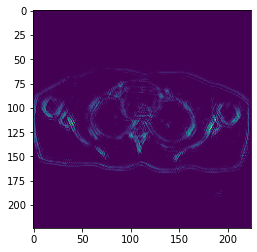

target heatmap


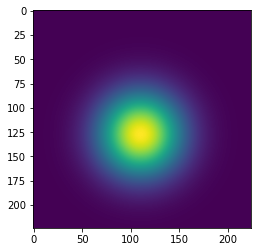

torch.Size([1, 224, 224])
image


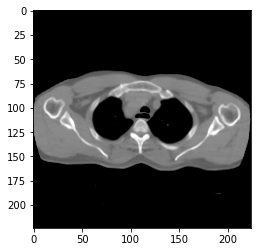

 ---- first image of set ---- (end)
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480

h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 480 480
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 500
new h, new w 224 224
h,w 500 50

KeyboardInterrupt: 

In [21]:
# train initialised model

#best_loss = 1e10
epoch_num = 50
train_set.dataset.__train__() 
model = train_model(model, optimizer, scheduler, alpha,reg,gamma,sigma, num_epochs=epoch_num)


Tue Dec 29 12:31:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.41       Driver Version: 452.41       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P8     3W /  N/A |   2025MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

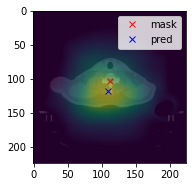

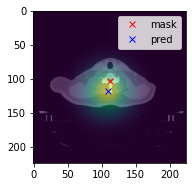

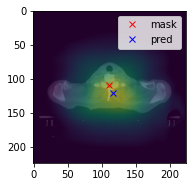

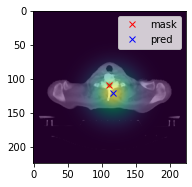

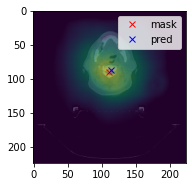

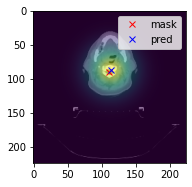

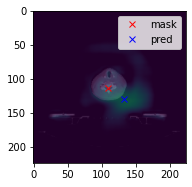

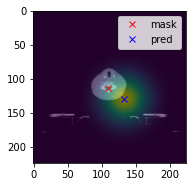

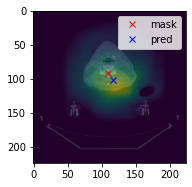

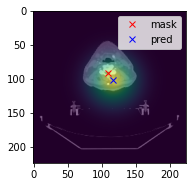

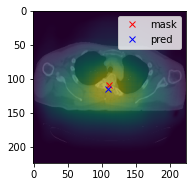

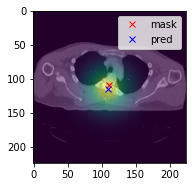

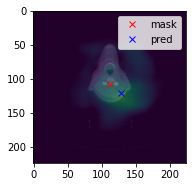

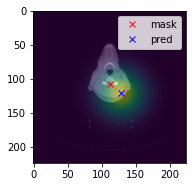

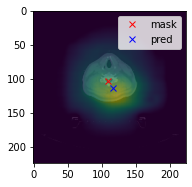

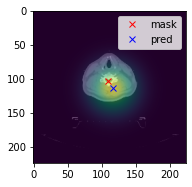

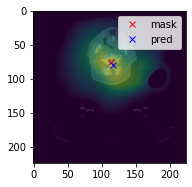

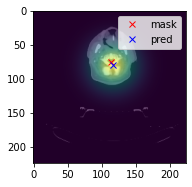

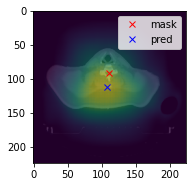

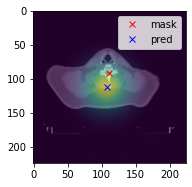

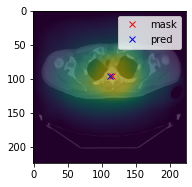

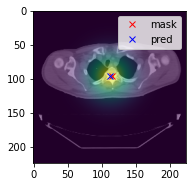

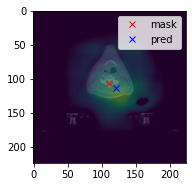

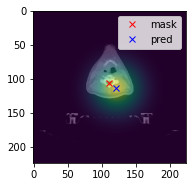

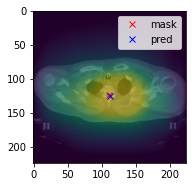

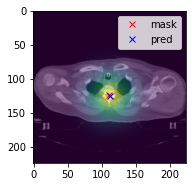

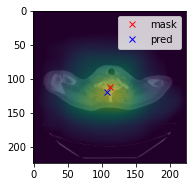

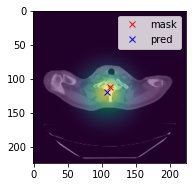

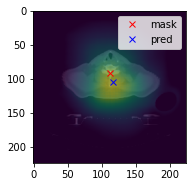

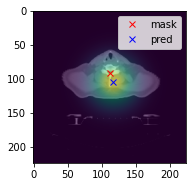

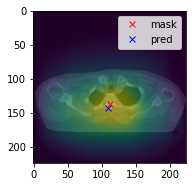

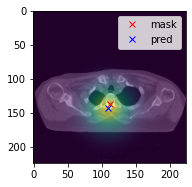

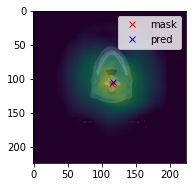

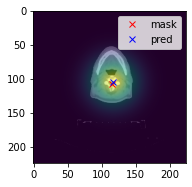

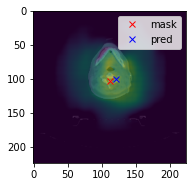

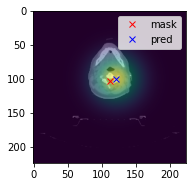

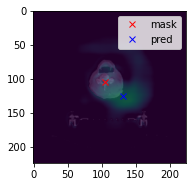

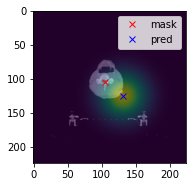

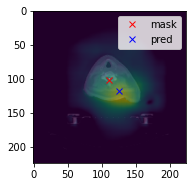

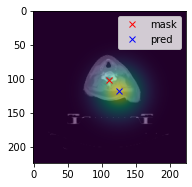

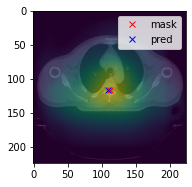

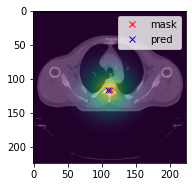

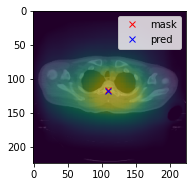

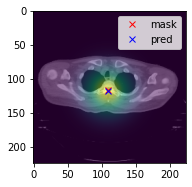

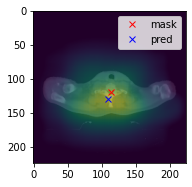

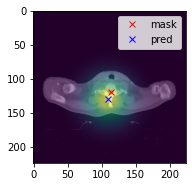

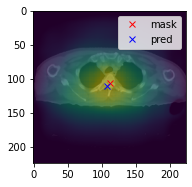

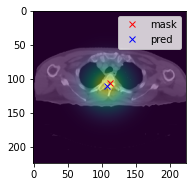

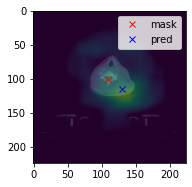

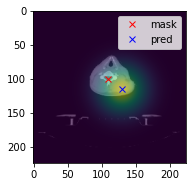

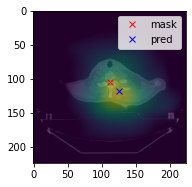

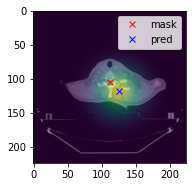

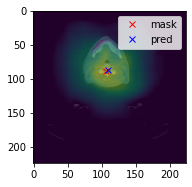

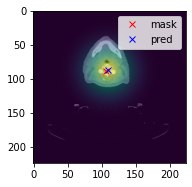

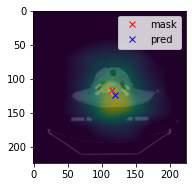

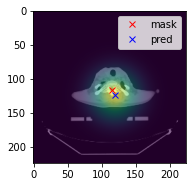

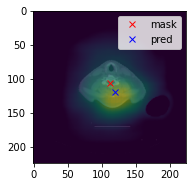

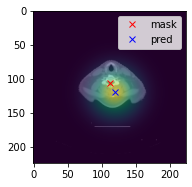

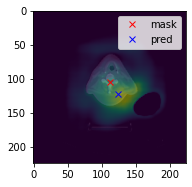

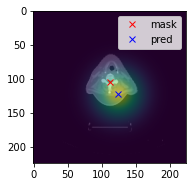

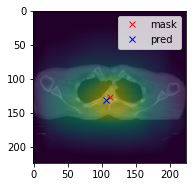

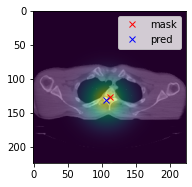

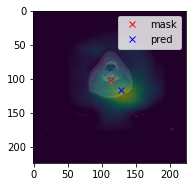

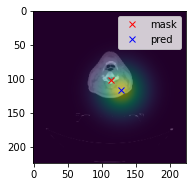

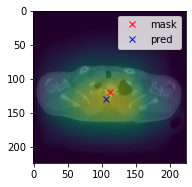

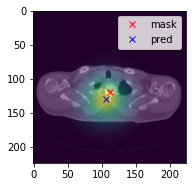

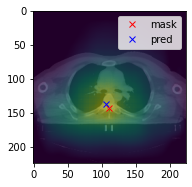

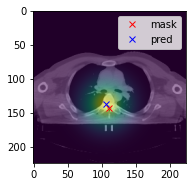

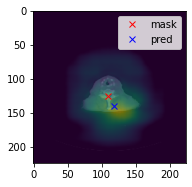

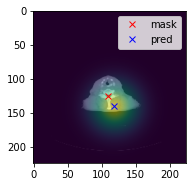

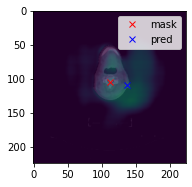

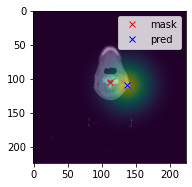

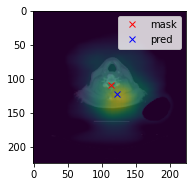

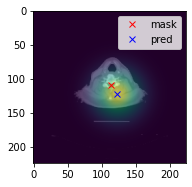

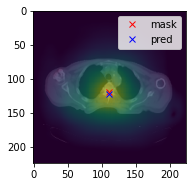

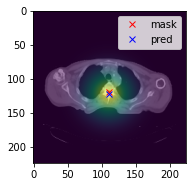

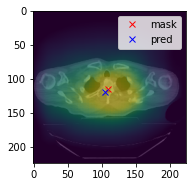

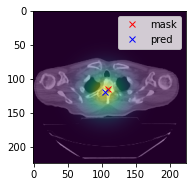

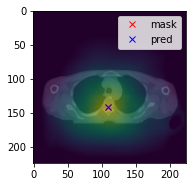

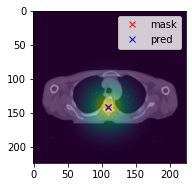

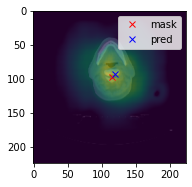

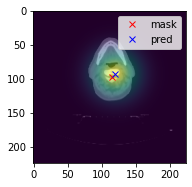

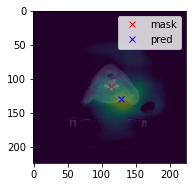

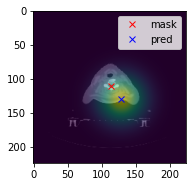

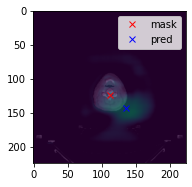

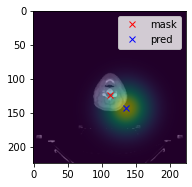

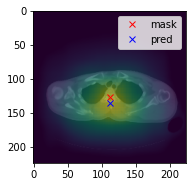

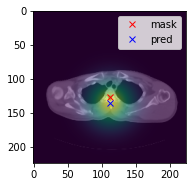

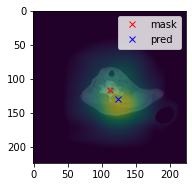

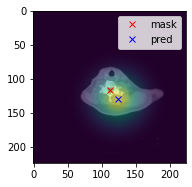

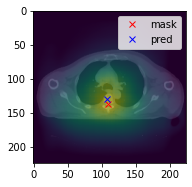

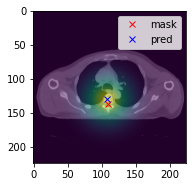

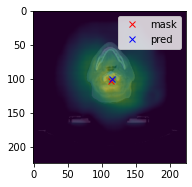

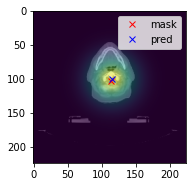

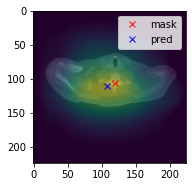

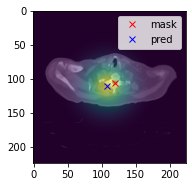

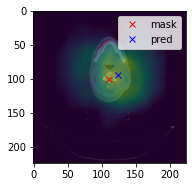

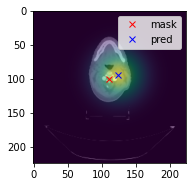

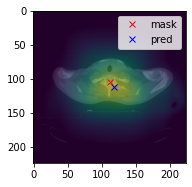

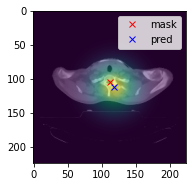

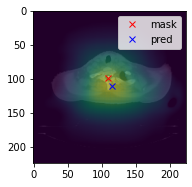

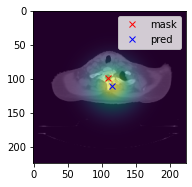

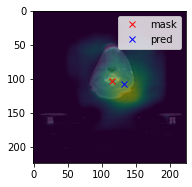

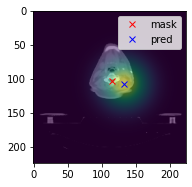

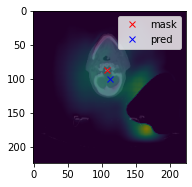

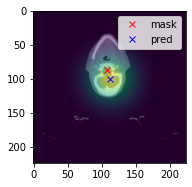

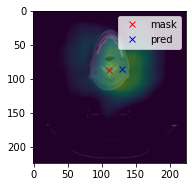

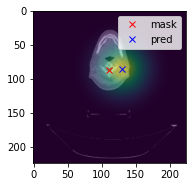

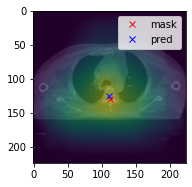

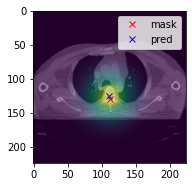

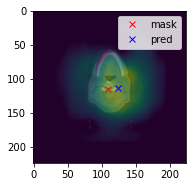

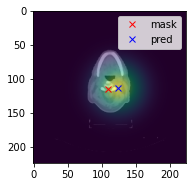

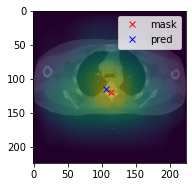

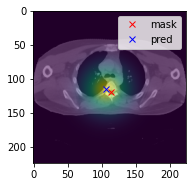

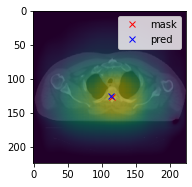

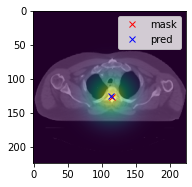

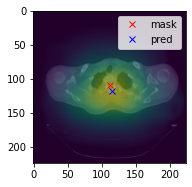

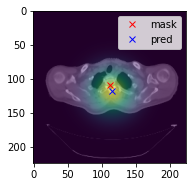

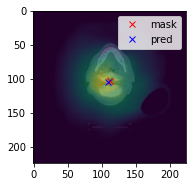

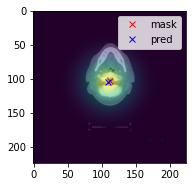

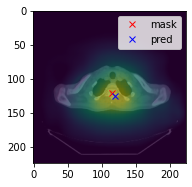

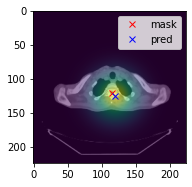

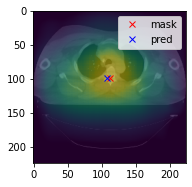

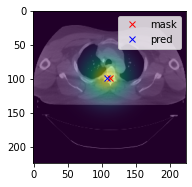

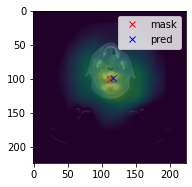

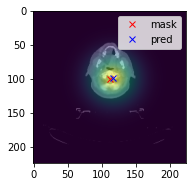

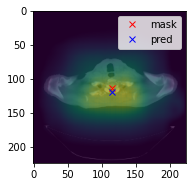

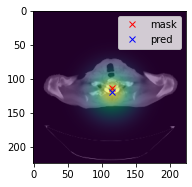

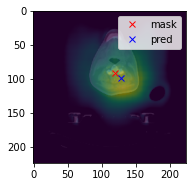

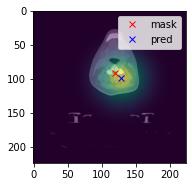

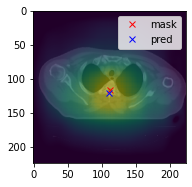

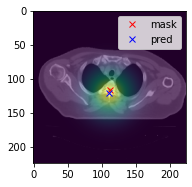

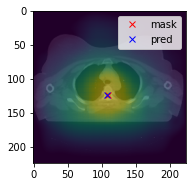

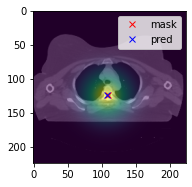

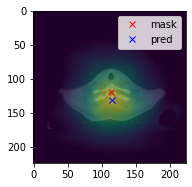

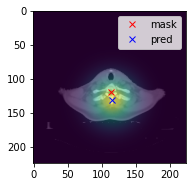

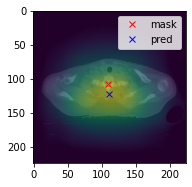

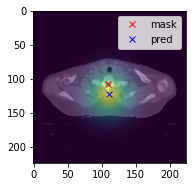

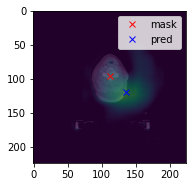

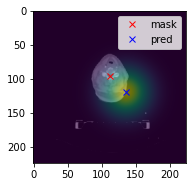

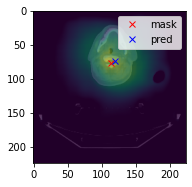

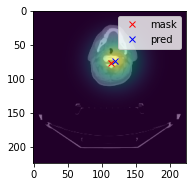

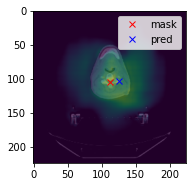

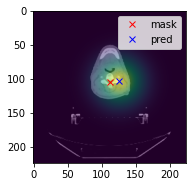

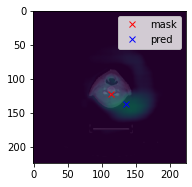

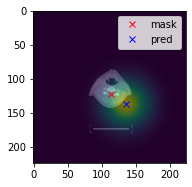

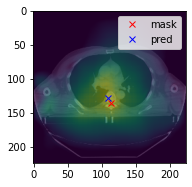

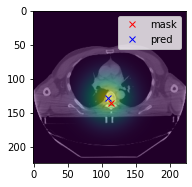

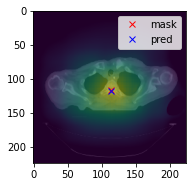

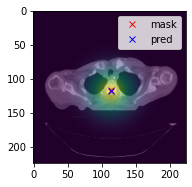

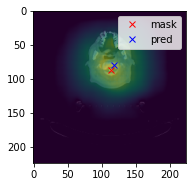

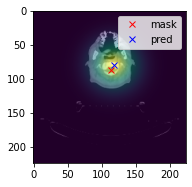

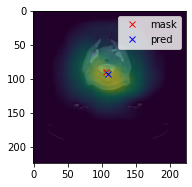

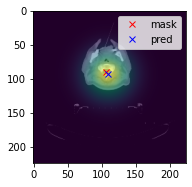

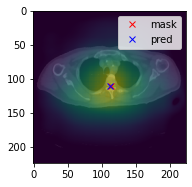

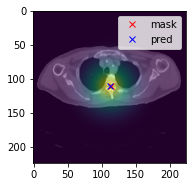

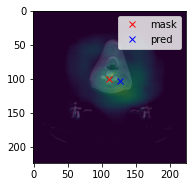

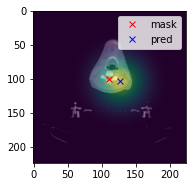

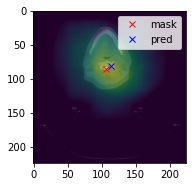

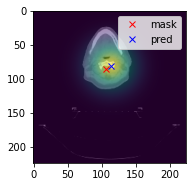

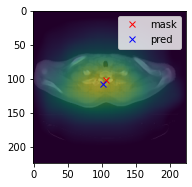

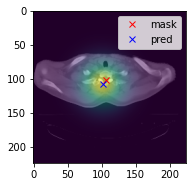

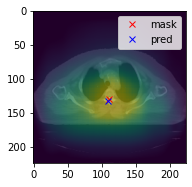

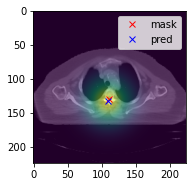

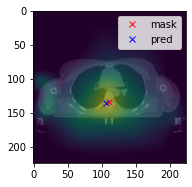

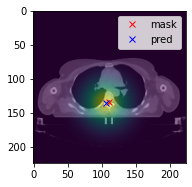

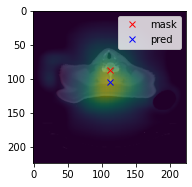

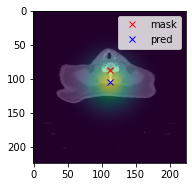

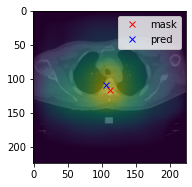

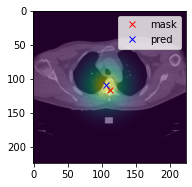

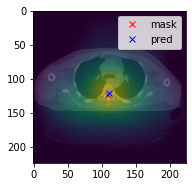

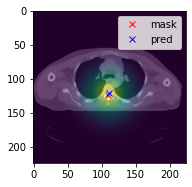

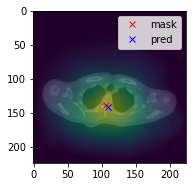

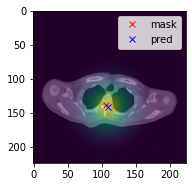

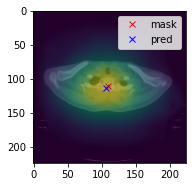

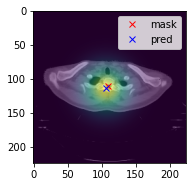

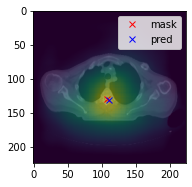

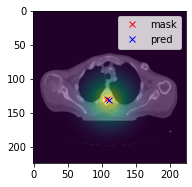

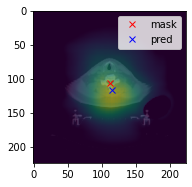

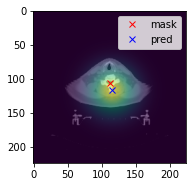

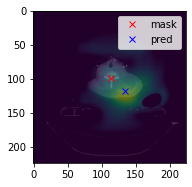

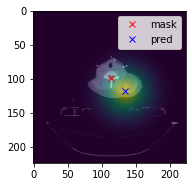

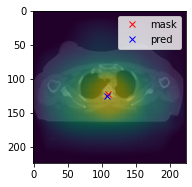

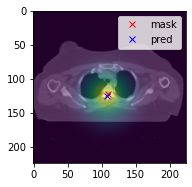

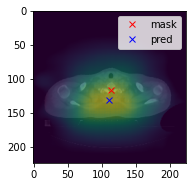

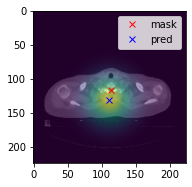

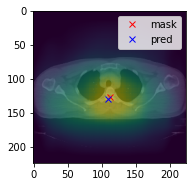

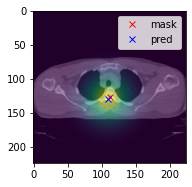

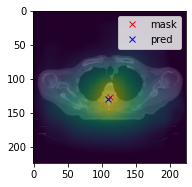

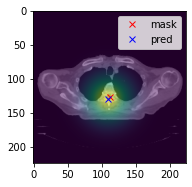

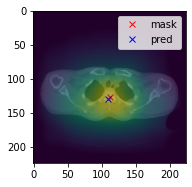

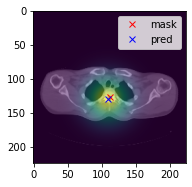

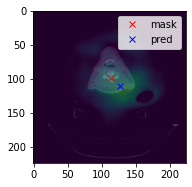

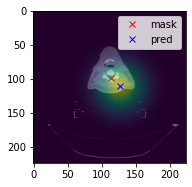

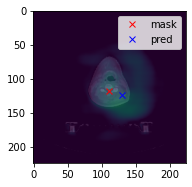

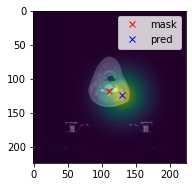

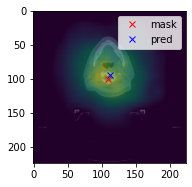

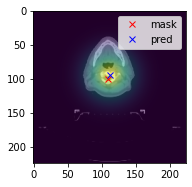

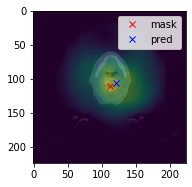

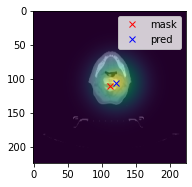

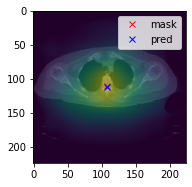

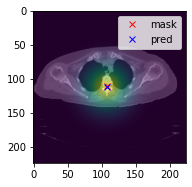

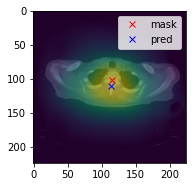

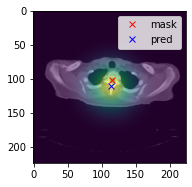

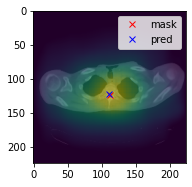

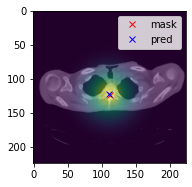

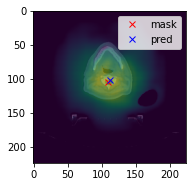

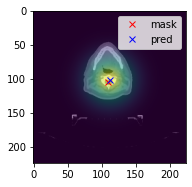

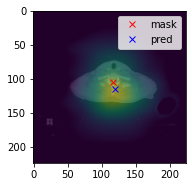

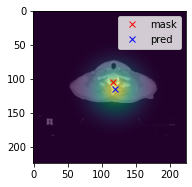

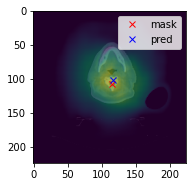

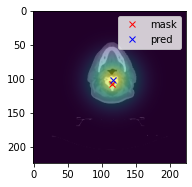

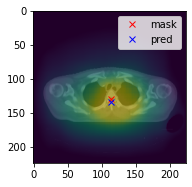

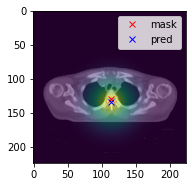

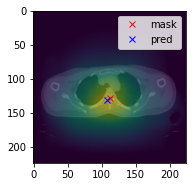

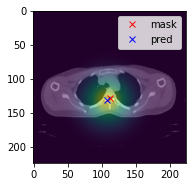

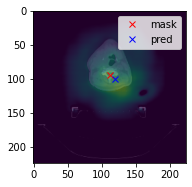

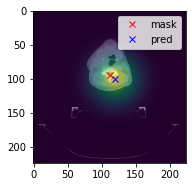

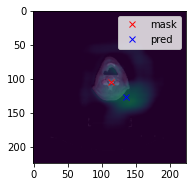

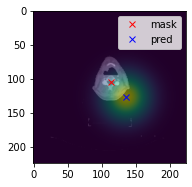

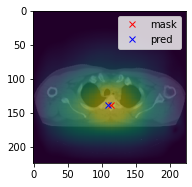

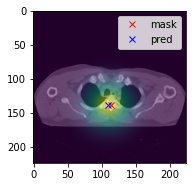

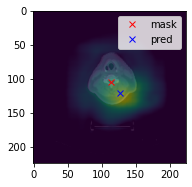

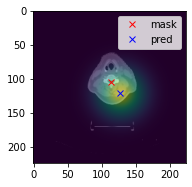

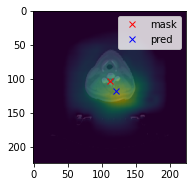

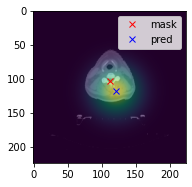

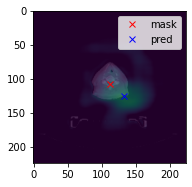

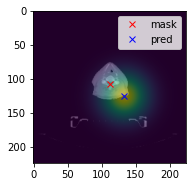

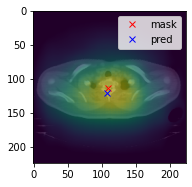

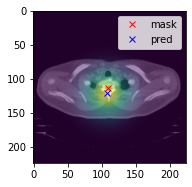

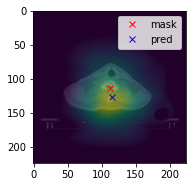

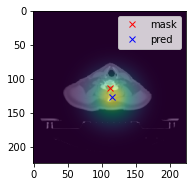

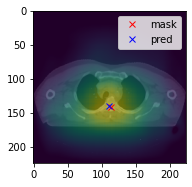

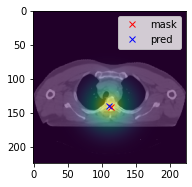

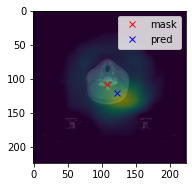

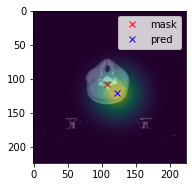

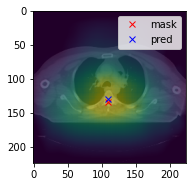

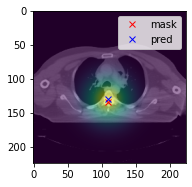

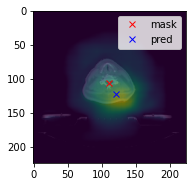

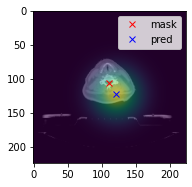

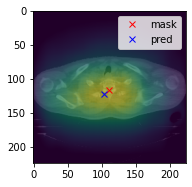

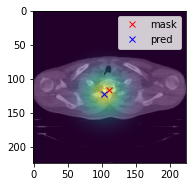

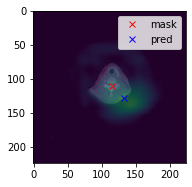

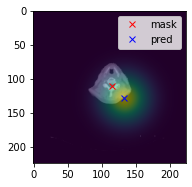

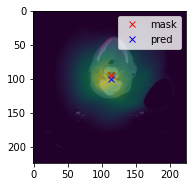

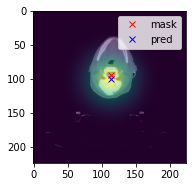

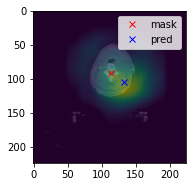

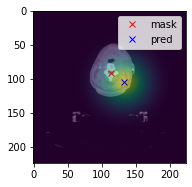

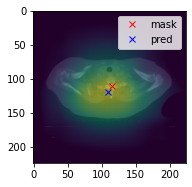

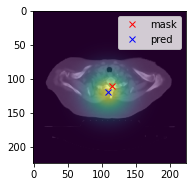

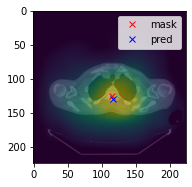

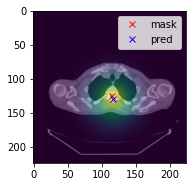

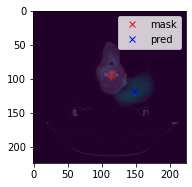

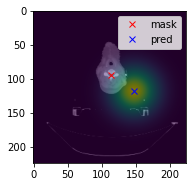

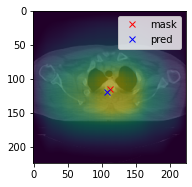

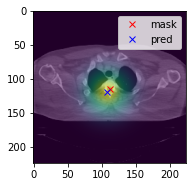

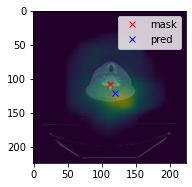

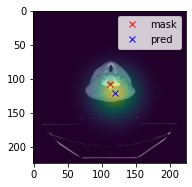

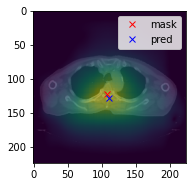

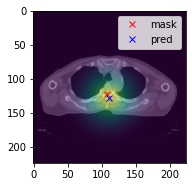

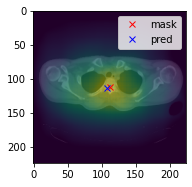

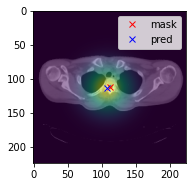

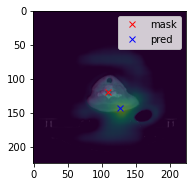

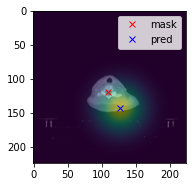

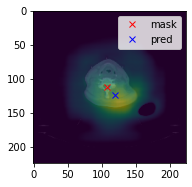

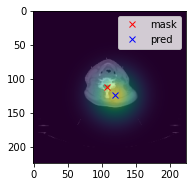

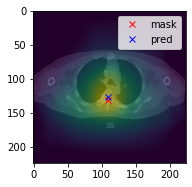

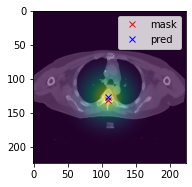

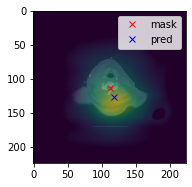

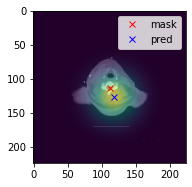

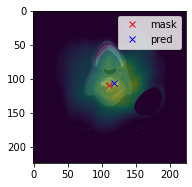

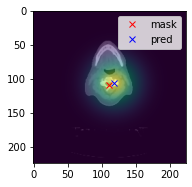

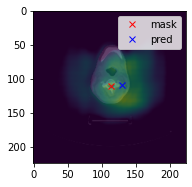

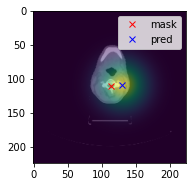

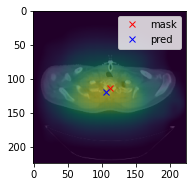

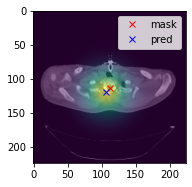

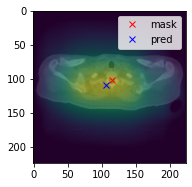

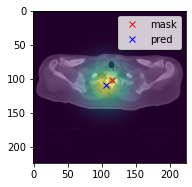

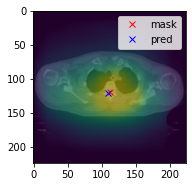

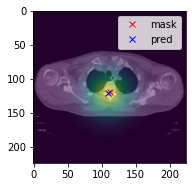

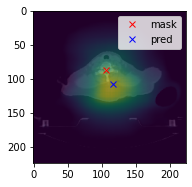

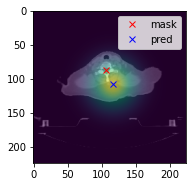

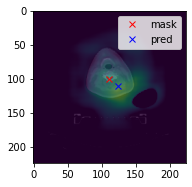

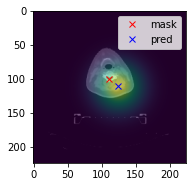

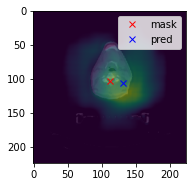

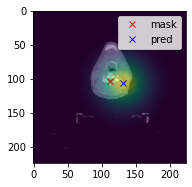

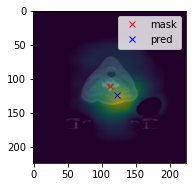

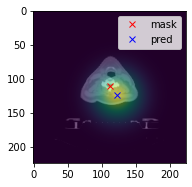

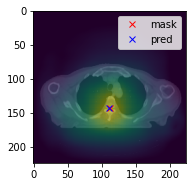

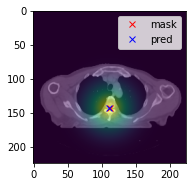

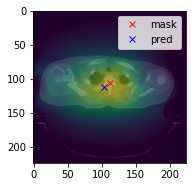

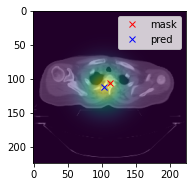

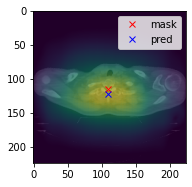

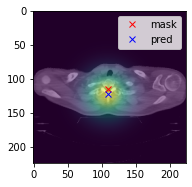

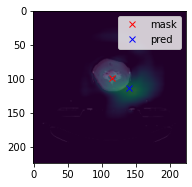

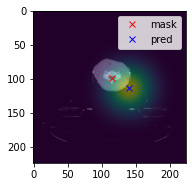

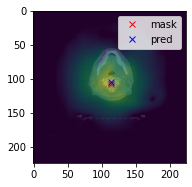

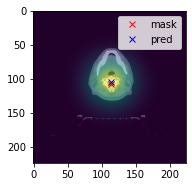

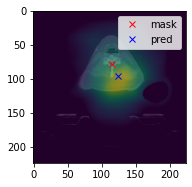

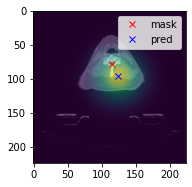

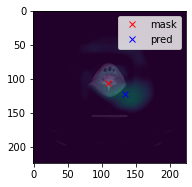

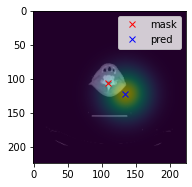

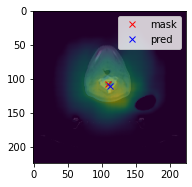

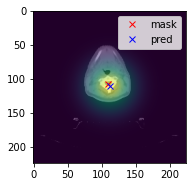

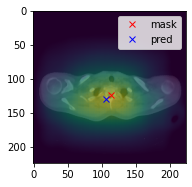

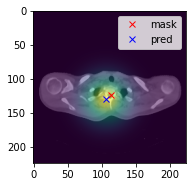

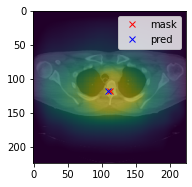

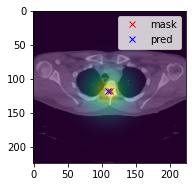

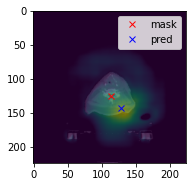

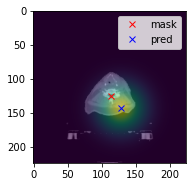

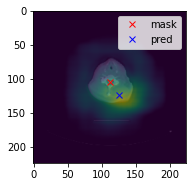

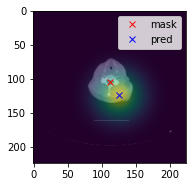

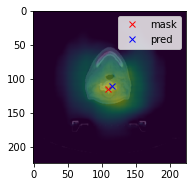

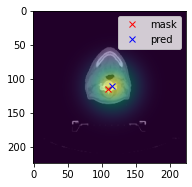

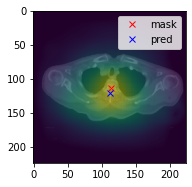

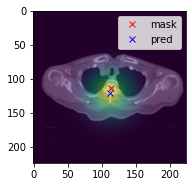

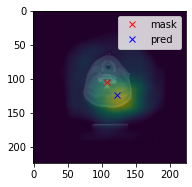

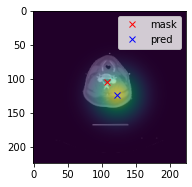

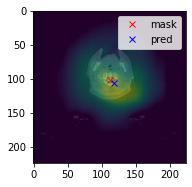

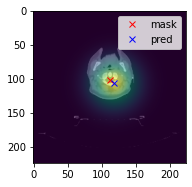

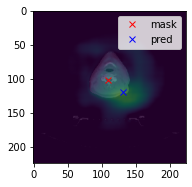

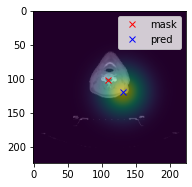

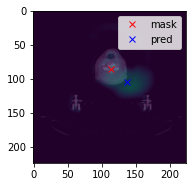

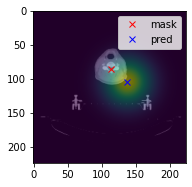

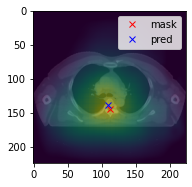

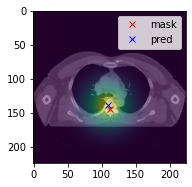

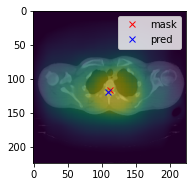

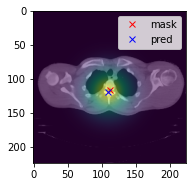

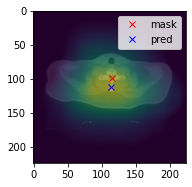

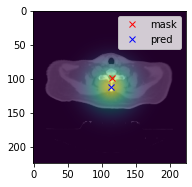

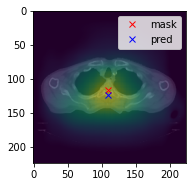

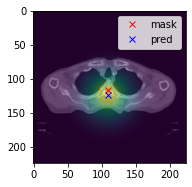

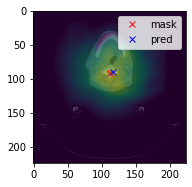

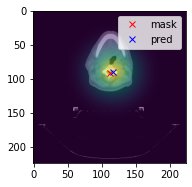

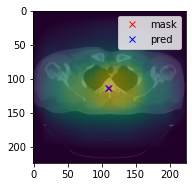

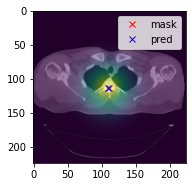

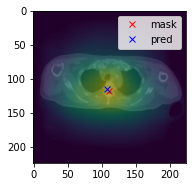

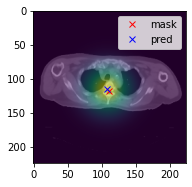

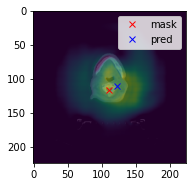

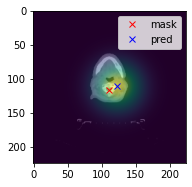

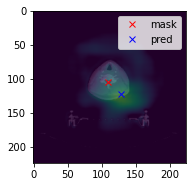

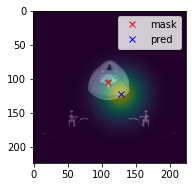

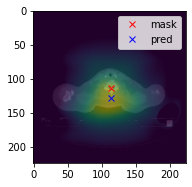

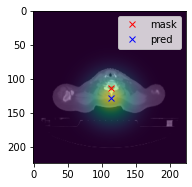

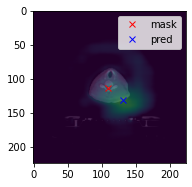

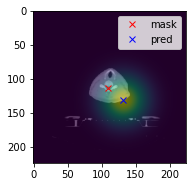

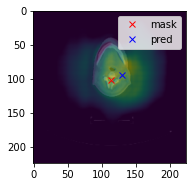

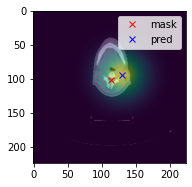

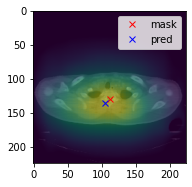

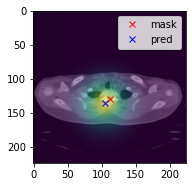

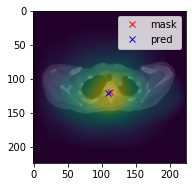

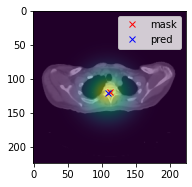

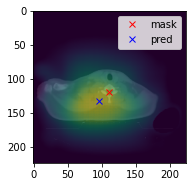

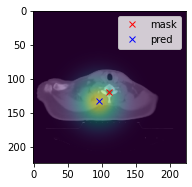

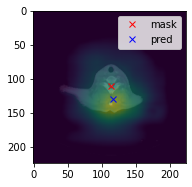

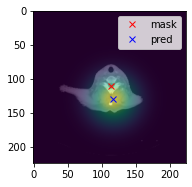

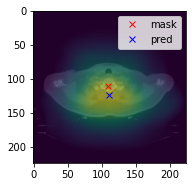

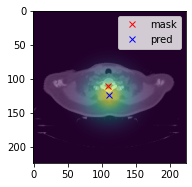

mean point to point error is 41.2431+/-4.502320739979936
median point to point error is 10.049875
percentage of images which were outliers is 36.87150837988827%
sigma is tensor([23.4435], device='cuda:0', requires_grad=True)


In [72]:
# evaluate initialised model

!nvidia-smi
model.eval()   # Set model to the evaluation mode
test_set.dataset.__test__() # sets whole dataset to test mode means it doesn't augment images
performance_metrics(model,sigma,gamma)


In [ ]:
# train loaded in model

# load in val loss
best_loss = torch.load(PATH_val_loss_load)['best_val_loss']

train_set.dataset.__train__() 
model_load = train_model(model_load, optimizer_load, scheduler, alpha,reg,gamma,sigma, num_epochs=epoch_num)

In [ ]:
# evaluate loaded in model

!nvidia-smi

model_load.eval()
test_set.dataset.__test__() # sets whole dataset to test mode means it doesn't augment images
performance_metrics(model_load,sigma,gamma)


In [69]:
# save model to documents
"""
# careful if uncommenting below could overwrite!!!

torch.save(model.state_dict(), PATH_save)
torch.save(optimizer.state_dict(), PATH_opt_save)
torch.save({
            'sigma': sigma,
            }, PATH_sigma_save) # change accordingly
#torch.save(scaler.state_dict(), PATH_scaler_save)
#torch.save({'best_val_loss': best_loss}, PATH_val_loss_save)
"""